In [106]:
import copy
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

from src.utils import load_all_csv_in_dir

In [160]:
data_dir = os.path.join("..", "PythonAnygrad", "save")
data = load_all_csv_in_dir(data_dir)
data = data.dropna(subset=["value"]).sort_values(by="total_time")

strategies = np.unique(data["strategy"])
targets = np.unique(data["target"])
num_strategies = len(strategies)
num_targets = len(targets)

data

,strategy,rep,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
1044,"Baseline (round robin, m=100)",3,5,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1026,"Baseline (round robin, m=100)",3,3,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1035,"Baseline (round robin, m=100)",3,4,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1053,"Baseline (round robin, m=100)",3,6,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1062,"Baseline (round robin, m=100)",3,7,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,"Baseline (round robin, m=200)",4,36,Target 9,-908.009197,200,800,7200,215.000536,4.181630,4.907212,0.005227,0.005111,0.000002,0.177484
665,"Baseline (round robin, m=200)",1,36,Target 9,-908.009197,200,800,7200,215.235770,4.176013,4.902915,0.005220,0.005111,0.000002,0.177654
998,"Baseline (round robin, m=200)",2,36,Target 9,-908.009197,200,800,7200,215.270755,4.180757,4.909684,0.005226,0.005111,0.000002,0.177417
1331,"Baseline (round robin, m=200)",3,36,Target 9,-908.009197,200,800,7200,215.428842,4.191738,4.925523,0.005240,0.005111,0.000002,0.176865


## Raw results
First plot the loss of each target over time

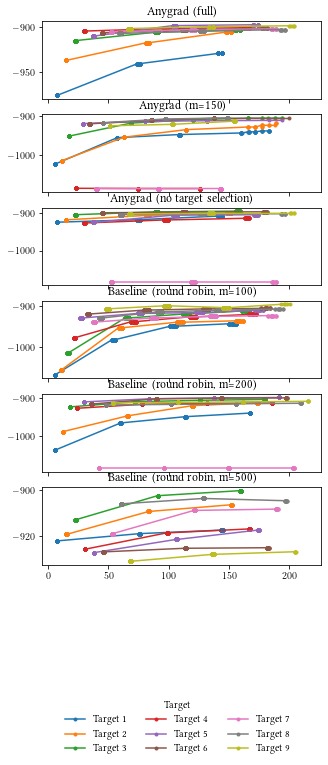

In [151]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for target in targets:
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(target_data["total_time"], target_data["value"], label=target, marker=".")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

## Imputation

1. We prepend the first non-nan value for each target of each strategy
2. For each timestamp in the data of one strategy we impute the value with the last one measured

In [152]:
def prepend_first_row(df: pd.DataFrame) -> pd.DataFrame:
    first_row = copy.deepcopy(df.iloc[[0]])
    first_row["total_time"] = 0.0
    first_row["total_iterations"] = 0.0
    first_row = pd.DataFrame(first_row, columns=df.columns)
    return pd.concat([first_row, df], ignore_index=True)


def impute(data: pd.DataFrame) -> pd.DataFrame:
    results = []
    targets = np.unique(data["target"])
    strategies = np.unique(data["strategy"])
    df_per_strategy = [data.sort_values(by="total_time")
                       .groupby(by=["strategy"])
                       .get_group(strategy) for strategy in strategies]
    for strategy_index, df in enumerate(df_per_strategy):
        unique_timepoints = np.unique(df["total_time"])
        for target in targets:
            target_data = df.groupby(by="target").get_group(target)
            target_data = prepend_first_row(target_data)
            target_data = target_data.reset_index()
            print(target_data)
            for timestamp in unique_timepoints:
                past_items = target_data[target_data["total_time"] < timestamp]
                if len(past_items):
                    copied_item = copy.deepcopy(past_items.iloc[0])
                    copied_item["total_time"] = timestamp
                    results.append(copied_item)
    return pd.DataFrame(results).reset_index(inplace=False, drop=True).drop(columns=["index"])

data

,strategy,rep,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
1044,"Baseline (round robin, m=100)",3,5,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1026,"Baseline (round robin, m=100)",3,3,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1035,"Baseline (round robin, m=100)",3,4,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1053,"Baseline (round robin, m=100)",3,6,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1062,"Baseline (round robin, m=100)",3,7,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,"Baseline (round robin, m=200)",4,36,Target 9,-908.009197,200,800,7200,215.000536,4.181630,4.907212,0.005227,0.005111,0.000002,0.177484
665,"Baseline (round robin, m=200)",1,36,Target 9,-908.009197,200,800,7200,215.235770,4.176013,4.902915,0.005220,0.005111,0.000002,0.177654
998,"Baseline (round robin, m=200)",2,36,Target 9,-908.009197,200,800,7200,215.270755,4.180757,4.909684,0.005226,0.005111,0.000002,0.177417
1331,"Baseline (round robin, m=200)",3,36,Target 9,-908.009197,200,800,7200,215.428842,4.191738,4.925523,0.005240,0.005111,0.000002,0.176865


In [155]:
data.sort_values(by="total_time")

,strategy,rep,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
1044,"Baseline (round robin, m=100)",3,5,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1026,"Baseline (round robin, m=100)",3,3,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1035,"Baseline (round robin, m=100)",3,4,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1053,"Baseline (round robin, m=100)",3,6,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
1062,"Baseline (round robin, m=100)",3,7,Target 1,-1067.666211,100,100,100,5.289535,0.511813,-0.511812,0.005118,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,"Baseline (round robin, m=200)",4,36,Target 9,-908.009197,200,800,7200,215.000536,4.181630,4.907212,0.005227,0.005111,0.000002,0.177484
665,"Baseline (round robin, m=200)",1,36,Target 9,-908.009197,200,800,7200,215.235770,4.176013,4.902915,0.005220,0.005111,0.000002,0.177654
998,"Baseline (round robin, m=200)",2,36,Target 9,-908.009197,200,800,7200,215.270755,4.180757,4.909684,0.005226,0.005111,0.000002,0.177417
1331,"Baseline (round robin, m=200)",3,36,Target 9,-908.009197,200,800,7200,215.428842,4.191738,4.925523,0.005240,0.005111,0.000002,0.176865


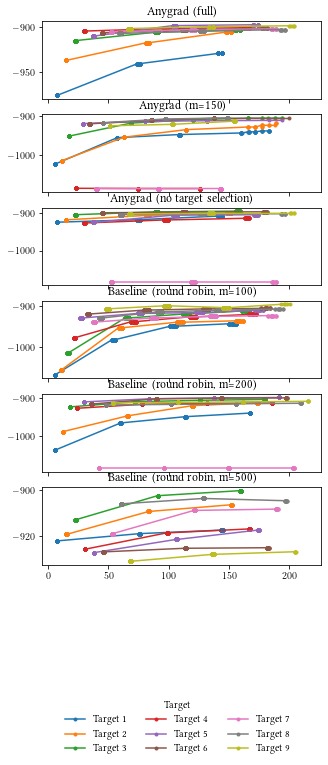

In [153]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for target in targets:
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(target_data["total_time"], target_data["value"], label=target, marker=".")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

## Average

Compute Average over all targets per strategy

In [77]:
grouped_data = data.groupby(by="strategy")
for strategy in strategies:
    strategy_data = grouped_data.get_group(strategy)
    unique_timestamps = np.unique(strategy_data["total_time"])
    grouped_data_by_timestamp = strategy_data.groupby("total_time")
    for timestamp in unique_timestamps:
        timestamp_data: pd.DataFrame = grouped_data_by_timestamp.get_group(timestamp)
        timestamp_data.mean()
        print(timestamp_data)



            strategy    target  total_time  \
0     Anygrad (full)  Target 1    7.370786   
135   Anygrad (full)  Target 2    7.370786   
270   Anygrad (full)  Target 3    7.370786   
405   Anygrad (full)  Target 4    7.370786   
540   Anygrad (full)  Target 5    7.370786   
675   Anygrad (full)  Target 6    7.370786   
810   Anygrad (full)  Target 7    7.370786   
945   Anygrad (full)  Target 8    7.370786   
1080  Anygrad (full)  Target 9    7.370786   

                                                  value  
0     index                            0
strategy   ...  
135   index                            0
strategy   ...  
270   index                            0
strategy   ...  
405   index                            0
strategy   ...  
540   index                            0
strategy   ...  
675   index                            0
strategy   ...  
810   index                            0
strategy   ...  
945   index                            0
strategy   ...  
1080  index      

In [148]:
alpha = 0.5

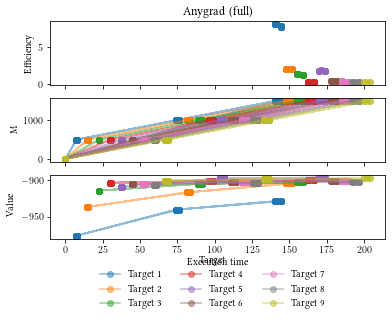

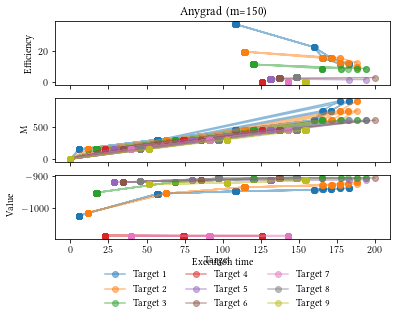

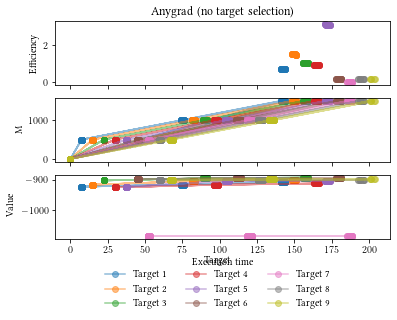

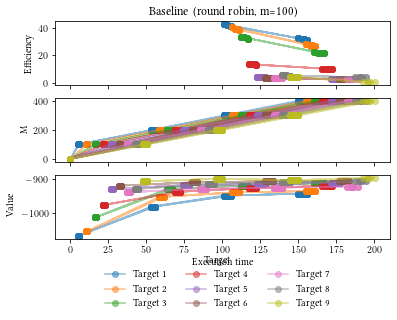

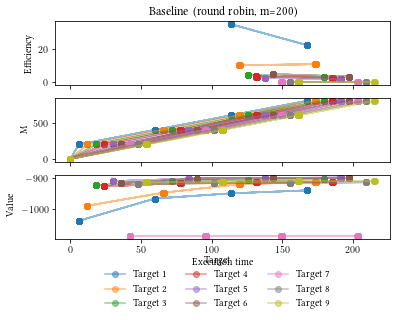

In [ ]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    for target in targets:
        target_data = this_data[this_data["target"] == target]
        axes[0].plot(target_data["total_time"], target_data["efficiency"], label=target, alpha=alpha, marker="o")
        axes[1].plot(target_data["total_time"], target_data["M"], label=target, alpha=alpha, marker="o")
        axes[2].plot(target_data["total_time"], target_data["value"], label=target, alpha=alpha, marker="o")
        axes[0].set_title(strategy)
    axes[0].set_ylabel("Efficiency")
    axes[1].set_ylabel("M")
    axes[2].set_ylabel("Value")
    axes[-1].set_xlabel("Execution time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

NameError: name 'alpha' is not defined

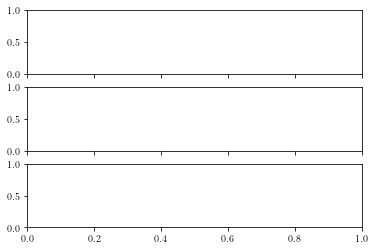

In [7]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    reps = np.unique(this_data["rep"])
    for target in targets:
        for rep in reps:
            target_data = this_data[np.logical_and(this_data["target"] == target, this_data["rep"] == rep)]
            axes[0].plot(target_data["total_time"], target_data["derivation_1st"] / target_data["t1"],
                         label=target, alpha=alpha, marker="x")
            axes[1].plot(target_data["total_time"], target_data["derivation_2nd"],
                         label=target, alpha=alpha, marker="x")
            axes[2].plot(target_data["total_time"], target_data["m"],
                         label=target, alpha=alpha, marker="x")
            axes[0].set_title(strategy)
    axes[0].set_ylabel("1st derivation")
    axes[1].set_ylabel("2nd derivation")
    axes[2].set_ylabel("value")
    axes[-1].set_xlabel("Execution Time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [40]:
def compute_auc(x, y):
    x = np.array(x)
    y = -np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]))
            for i in range(1, len(y), 1)]
    return x[1:], area

def compute_auc_remaining(x, y, offset: float):
    x = np.array(x)
    y = np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = np.nanmin(y) - y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]) + offset*(x[i-1]-x[0]))
            for i in range(1, len(y), 1)]
    return x[1:], area

def group_df(df: pd.DataFrame):
    df = df.sort_values(by="total_iterations").groupby(by=["strategy", "target"])
    return df

In [42]:
imputed_data = prepare_data(data)

            strategy  rep  context_change    target       value    m     M  \
0     Anygrad (full)    0               0  Target 1         NaN    0     0   
252   Anygrad (full)    1               0  Target 1         NaN    0     0   
1008  Anygrad (full)    4               0  Target 1         NaN    0     0   
756   Anygrad (full)    3               0  Target 1         NaN    0     0   
504   Anygrad (full)    2               0  Target 1         NaN    0     0   
...              ...  ...             ...       ...         ...  ...   ...   
207   Anygrad (full)    0              23  Target 1 -929.172352  500  1500   
198   Anygrad (full)    0              22  Target 1 -929.172352  500  1500   
189   Anygrad (full)    0              21  Target 1 -929.172352  500  1500   
225   Anygrad (full)    0              25  Target 1 -929.172352  500  1500   
243   Anygrad (full)    0              27  Target 1 -929.172352  500  1500   

      total_iterations  total_time  time_on_target  t_switch   

In [43]:
imputed_data

,strategy,target,total_time,value


In [46]:
unique_strategies = np.unique(data["strategy"])
unique_targets = np.unique(data["target"])
dataframes = []
for strategy in unique_strategies:
    df = None
    data_for_strategy = imputed_data[imputed_data["strategy"] == strategy].groupby("target")
    for target in unique_targets:
        current_data = data_for_strategy.get_group(target)
        x, y = compute_auc(current_data["total_time"], current_data["value"])
        entries = np.array([[target for _ in x], x, y])
        df = entries.T if df is None else np.vstack([df, entries.T])
    df = pd.DataFrame(df, columns=["target", "total_time", "value"])
    dataframes.append(df)


KeyError: 'Target 1'

No handles with labels found to put in legend.


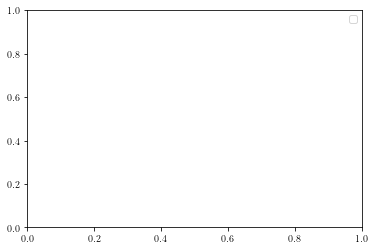

In [45]:
for df, strategy in zip(dataframes, unique_strategies):
    grouped_dataframe = df.groupby(by="target")
    total_time = np.array(df["total_time"], dtype=float)
    values = np.array(df["value"], dtype=float)
    x = np.array(np.unique(total_time), dtype=float)
    print(len(x))
    x.sort()
    y = [np.nanmean(values[total_time == ts]) for ts in x]
    plt.plot(x[150:200], y[150:200], label=strategy)
plt.legend()
plt.show()

In [ ]:
min_losses = [np.nanmin(df["value"]) for df in df_per_strategy]
offsets = np.array(min_losses) - np.nanmin(min_losses)
offset = np.nanmax(min_losses)
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = compute_auc_remaining(x, y, offset=offsets[i])
    plt.plot(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Average AUC in $[T_0, T]$")
plt.show()


In [ ]:
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    plt.scatter(x, y, label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Running mean in $[T_0, T]$")
plt.show()

In [ ]:
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = compute_auc(x, y)
    plt.plot(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"AU Loss Curve in $[T_0, T]$")
plt.show()

In [ ]:
grouped_df = group_df(data)
indices = grouped_df.indices
strategies = np.unique([index[0] for index in indices.keys()])
targets = np.unique([index[1] for index in indices.keys()])

fig, axes = plt.subplots(nrows=len(strategies), ncols=1, sharey="all", sharex="all", figsize=(6,12))
for i, strat in enumerate(strategies):
    for target in targets:
        current_data = grouped_df.get_group((strat, target))
        current_data = prepend_first_row(current_data)
        x = current_data["total_time"]
        x, auc = get_auc(x,
                         y=current_data["value"])
        axes[i].plot(x,
                     auc,
                     label=target)
    axes[i].set_title(strat)
    axes[i].set_ylabel("Value")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
axes[-1].set_xlabel("Execution time")
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.05, 1, 1),
                    frameon=False, ncol=3, title="Target")
plt.tight_layout()
plt.show()

In [ ]:
y = [-4.39331878, -3.93170969, -3.65555667, -3.45794343, -3.30895812, -3.1925142,
     -3.09831504, -3.02023389, -2.95436115]
x = [3.,  6.,  9., 12., 15., 18., 21., 24., 27.]
coefficients = [-2.54097250e-03, 1.31063455e-01, -4.68765366e+00]

def q_function(x):
    return coefficients[0] * x*x + coefficients[1] * x + coefficients[2]

plt.scatter(x, y, marker="x", label="Measurements")
plt.plot(x, q_function(np.array(x)), label="Fitted curve")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.legend()
plt.show()